# Weighted Wang-Parr inversion testing
This notebook contains code related to testing the implementation of the weighted Wang-Parr inversion scheme \
By: Anthony R. Osborne

In [ ]:
import iDEA
import pickle
import numpy as np
import matplotlib.pyplot as plt
from tools import thermal_interacting_tools as tit
from scipy.integrate import simpson as simps 
import matplotlib.animation as animation
from IPython.display import HTML

In [4]:
### Set Various options that are used later in the code
read = True
write = False

In [ ]:
x = np.linspace(-5, 5, 402)
ks = np.arange(1, 100)
v_ext = tit.atomic_potentials(2, x, potential_type=1, d=0)
v_int = iDEA.interactions.softened_interaction(x)
He = iDEA.system.System(x, v_ext, v_int, electrons='ud')
unweighted_ground_State = iDEA.methods.non_interacting.solve(He)

iDEA.methods.non_interacting.solve: convergence = 1.0634e-11, tolerance = 1e-10


In [ ]:
# if write:
#     with open('excited_states.pkl', 'wb') as es_file:
#         pickle.dump(excited_states, es_file, protocol=pickle.HIGHEST_PROTOCOL) #dumping the actual list

In [5]:
if read:
    with open('../interacting_data/excited_states0.pkl', 'rb') as es_file:
        excited_states = pickle.load(es_file) #load list

#just for verification
print(f"Loaded {len(excited_states)} states")
if len(excited_states) < 1:
    raise Exception("Error it appears no states were loaded") #iDEA state object type, or should show them

    # print(excited_states[1].energy)


FileNotFoundError: [Errno 2] No such file or directory: '../interacting_data/excited_states0.pkl'

In [ ]:
# print(excited_states[1])

In [ ]:
unweighted_ground_State_density = iDEA.observables.density(harmonic_oscillator, unweighted_ground_State)

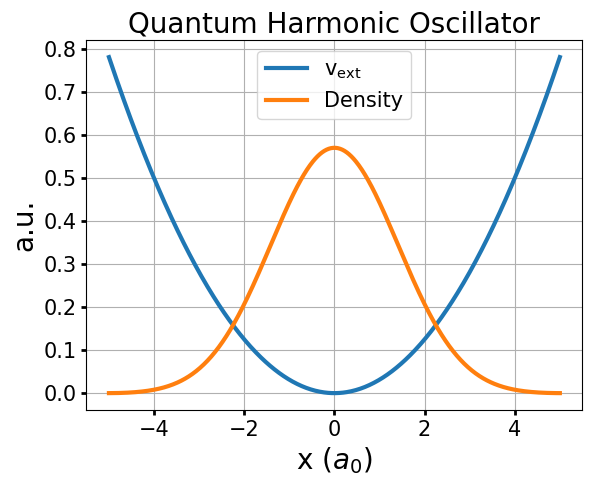

In [ ]:
#---------------> Plot
fig, ax = plt.subplots(1, 1)#, dpi=200)
#---------------> Data
ax.plot(x, v_ext, linewidth=3, label=r"$\rm v_{ext}$")
ax.plot(x, unweighted_ground_State_density, linewidth=3, label="Density")
#---------------> Formatting
ax.set_title(r"Quantum Harmonic Oscillator", fontsize = 20)
ax.set_ylabel(r"a.u.", fontsize = 20)
ax.set_xlabel(r"x ($a_0$)", fontsize = 20)
ax.grid(True)
ax.legend(loc="best", fontsize=15)
ax.xaxis.set_tick_params(width=2)
ax.yaxis.set_tick_params(width=2)
#-------> Borders 
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 2.0
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [ ]:
# Nx = len(x)
# nk = 500
# v_ext = np.zeros(Nx)

# dx = x[1]-x[0]
# diag = (np.ones(Nx)/dx**2)
# # print(diag)
# diags = np.array([(v_ext+diag),(diag/-2),(diag/-2)])

# H = spa.dia_matrix((diags,[0,-1,1]),shape=(Nx,Nx))
# vals, vecs = eigsh(H,which='SA',k=nk)

# vec_sum = np.trapz(vecs[:,0]**2,x)
# norm = np.sqrt(1/vec_sum)
# vecs = vecs*norm
iDEA_vecs = []
iDEA_vals= []
for i in range(0, 499):
    # print(i)
    state = excited_states[i]
    iDEA_vals.append(state.up.energies)
    iDEA_vecs.append(state.up.orbitals)
    #convert lists to arrays 
    iDEA_vals_array = np.array(iDEA_vals)
    iDEA_vecs_array = np.array(iDEA_vecs[i])

In [ ]:
taus = np.linspace(1,5,499)
mus = np.linspace(-5,5,10000)
dtau = taus[1]-taus[0]
mus = [] #np.empty(len(taus))
Nes = [] #np.empty(len(taus))
mu0s = [] #np.empty(len(taus))
mu1s= [] #np.empty(len(taus))
mu_upper = []#np.empty(len(taus))

mu0 = 4
mu1 = 5
# test 
for i,tau in enumerate(taus):
    mu_upper.append(mu1)
    
    func = tit.fermi_particle_number_shifter(tau,iDEA_vals_array[i],iDEA_vecs [i],x,2) 
    mu1,fx0 = tit.secant_method(mu0,mu1,func,criterion=1e-10)
    
    mu0s.append(mu0)
    mu1s.append(mu1)
    
    mus.append(mu1)
    Nes.append(tit.fermi_particle_number_function(mu1,tau,iDEA_vals_array[i],iDEA_vecs[i],x))
    
    mu0 = mu1-(dtau+(.1*dtau*i))

/opt/anaconda3/lib/python3.11/site-packages/tools/thermal_interacting_tools.py:59: RuntimeWarning: overflow encountered in exp
  F_occs = 1/(1+np.exp((Eis-mu)/tau))


In [ ]:
for i,mu in enumerate(mus):
    occs = tit.fermi_occs(iDEA_vals, mu, taus[i])
    weighted_density = tit.fermi_dens_function(occs, iDEA_vecs_array, x)
    # print(f"for iteration {i}, the weighted density is: {np.max(weighted_density)}")

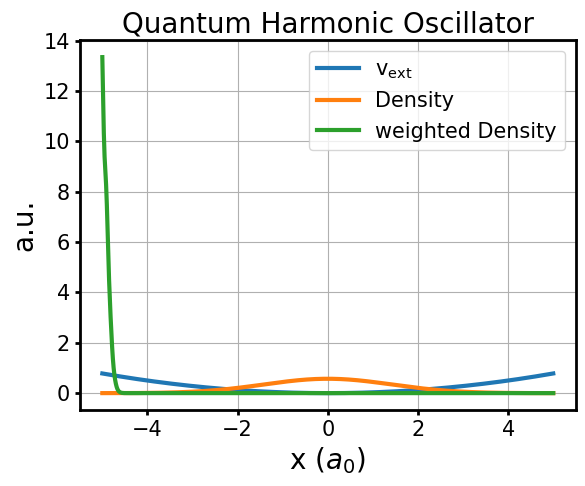

In [ ]:
#---------------> Plot
fig, ax = plt.subplots(1, 1)#, dpi=200)
#---------------> Data
ax.plot(x, v_ext, linewidth=3, label=r"$\rm v_{ext}$")
ax.plot(x, unweighted_ground_State_density, linewidth=3, label="Density")
ax.plot(x, weighted_density, linewidth=3, label="weighted Density")
#---------------> Formatting
ax.set_title(r"Quantum Harmonic Oscillator", fontsize = 20)
ax.set_ylabel(r"a.u.", fontsize = 20)
ax.set_xlabel(r"x ($a_0$)", fontsize = 20)
ax.grid(True)
ax.legend(loc="best", fontsize=15)
ax.xaxis.set_tick_params(width=2)
ax.yaxis.set_tick_params(width=2)
#-------> Borders 
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 2.0
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [ ]:
#Testing inversion
iDEA.reverse_engineering.reverse(harmonic_oscillator, target_n=weighted_density, method=iDEA.methods.non_interacting, scheme=2, tol=1e-6, occs_calc=True, chem_u=mu, tau=tau)

/opt/anaconda3/lib/python3.11/site-packages/iDEA/reverse_engineering.py:200: RuntimeWarning: overflow encountered in exp
  F_occs = 1/(1+np.exp((Eis-chem_u)/tau))
/opt/anaconda3/lib/python3.11/site-packages/iDEA/reverse_engineering.py:205: RuntimeWarning: divide by zero encountered in divide
  update_term = ((target_n - weighted_density)/(denom))*0.001
/opt/anaconda3/lib/python3.11/site-packages/iDEA/reverse_engineering.py:205: RuntimeWarning: invalid value encountered in divide
  update_term = ((target_n - weighted_density)/(denom))*0.001


ValueError: array must not contain infs or NaNs